In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import concatenate_datasets

In [2]:
# Optional: Disable symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the full IMDB dataset
dataset = load_dataset("imdb")

# Print label distribution for better understanding
print("Training dataset label distribution:", dataset["train"].features["label"].names)
print("Test dataset label distribution:", dataset["test"].features["label"].names)

Using device: cuda
Training dataset label distribution: ['neg', 'pos']
Test dataset label distribution: ['neg', 'pos']


In [3]:
# Separate the positive and negative samples from the training and test sets
positive_train_data = dataset["train"].filter(lambda example: example["label"] == 1)
negative_train_data = dataset["train"].filter(lambda example: example["label"] == 0)

positive_test_data = dataset["test"].filter(lambda example: example["label"] == 1)
negative_test_data = dataset["test"].filter(lambda example: example["label"] == 0)



# Balance the datasets by selecting an equal number of samples from both classes
balanced_train_data = concatenate_datasets([positive_train_data.select(range(2500)), negative_train_data.select(range(2500))])
balanced_test_data = concatenate_datasets([positive_test_data.select(range(400)), negative_test_data.select(range(400))])


In [4]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing...")
tokenized_train = balanced_train_data.map(tokenize_function, batched=True)
tokenized_test = balanced_test_data.map(tokenize_function, batched=True)
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Tokenizing...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [5]:
# DataLoader
train_loader = DataLoader(tokenized_train, batch_size=64, shuffle=True)
test_loader = DataLoader(tokenized_test, batch_size=64,  shuffle= False)

In [6]:
# Model definition
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.fc(cls_output)


In [7]:
model = BERTClassifier(BertModel.from_pretrained("bert-base-uncased")).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scaler = GradScaler(device)

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):  # 20 epochs
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)  # shape: (B, 1)

        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=total_loss / (total / 8), acc=correct / total)

    # Record training metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().unsqueeze(1).to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")


Epoch 1: 100%|██████████| 79/79 [09:55<00:00,  7.54s/it, acc=0.823, loss=0.0515]


Epoch 1 | Train Loss: 0.4071, Acc: 0.8232 | Val Loss: 0.2606, Acc: 0.8888


Epoch 2: 100%|██████████| 79/79 [09:51<00:00,  7.49s/it, acc=0.93, loss=0.0258] 


Epoch 2 | Train Loss: 0.2045, Acc: 0.9298 | Val Loss: 0.2602, Acc: 0.8988


Epoch 3: 100%|██████████| 79/79 [09:54<00:00,  7.52s/it, acc=0.966, loss=0.0134]


Epoch 3 | Train Loss: 0.1060, Acc: 0.9664 | Val Loss: 0.2789, Acc: 0.8900


Epoch 4: 100%|██████████| 79/79 [10:05<00:00,  7.66s/it, acc=0.98, loss=0.00878] 


Epoch 4 | Train Loss: 0.0694, Acc: 0.9802 | Val Loss: 0.2986, Acc: 0.9075


Epoch 5: 100%|██████████| 79/79 [09:53<00:00,  7.51s/it, acc=0.988, loss=0.00541]


Epoch 5 | Train Loss: 0.0428, Acc: 0.9884 | Val Loss: 0.3593, Acc: 0.9000


Epoch 6: 100%|██████████| 79/79 [10:00<00:00,  7.60s/it, acc=0.989, loss=0.00479]


Epoch 6 | Train Loss: 0.0379, Acc: 0.9894 | Val Loss: 0.3361, Acc: 0.9050


Epoch 7: 100%|██████████| 79/79 [09:56<00:00,  7.55s/it, acc=0.994, loss=0.00296]


Epoch 7 | Train Loss: 0.0234, Acc: 0.9944 | Val Loss: 0.3405, Acc: 0.9175


Epoch 8: 100%|██████████| 79/79 [09:56<00:00,  7.55s/it, acc=0.996, loss=0.00211]


Epoch 8 | Train Loss: 0.0167, Acc: 0.9956 | Val Loss: 0.3704, Acc: 0.9150


Epoch 9: 100%|██████████| 79/79 [09:56<00:00,  7.56s/it, acc=0.994, loss=0.00284]


Epoch 9 | Train Loss: 0.0225, Acc: 0.9942 | Val Loss: 0.3557, Acc: 0.9150


Epoch 10: 100%|██████████| 79/79 [09:53<00:00,  7.52s/it, acc=0.991, loss=0.00306]


Epoch 10 | Train Loss: 0.0242, Acc: 0.9912 | Val Loss: 0.4179, Acc: 0.9038


Epoch 11: 100%|██████████| 79/79 [09:49<00:00,  7.46s/it, acc=0.998, loss=0.0012]  


Epoch 11 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.4487, Acc: 0.9050


Epoch 12: 100%|██████████| 79/79 [09:42<00:00,  7.37s/it, acc=0.999, loss=0.000816]


Epoch 12 | Train Loss: 0.0065, Acc: 0.9988 | Val Loss: 0.4676, Acc: 0.9000


Epoch 13: 100%|██████████| 79/79 [09:42<00:00,  7.37s/it, acc=0.996, loss=0.00143] 


Epoch 13 | Train Loss: 0.0113, Acc: 0.9956 | Val Loss: 0.4379, Acc: 0.9062


Epoch 14: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.996, loss=0.00167] 


Epoch 14 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.4544, Acc: 0.8962


Epoch 15: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.997, loss=0.0013]  


Epoch 15 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.3810, Acc: 0.9113


Epoch 16: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.999, loss=0.000477]


Epoch 16 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.5142, Acc: 0.8925


Epoch 17: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.998, loss=0.00091] 


Epoch 17 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.4437, Acc: 0.9100


Epoch 18: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.999, loss=0.000467]


Epoch 18 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.6213, Acc: 0.8862


Epoch 19: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=0.999, loss=0.000344]


Epoch 19 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.5235, Acc: 0.9025


Epoch 20: 100%|██████████| 79/79 [09:41<00:00,  7.36s/it, acc=1, loss=7.06e-5]


Epoch 20 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.5580, Acc: 0.9125


In [9]:
# Evaluation of the model
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)

        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

In [10]:
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9125


In [11]:
# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(all_labels, all_preds))


Classification Report (Test Data):
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       400
         1.0       0.93      0.90      0.91       400

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



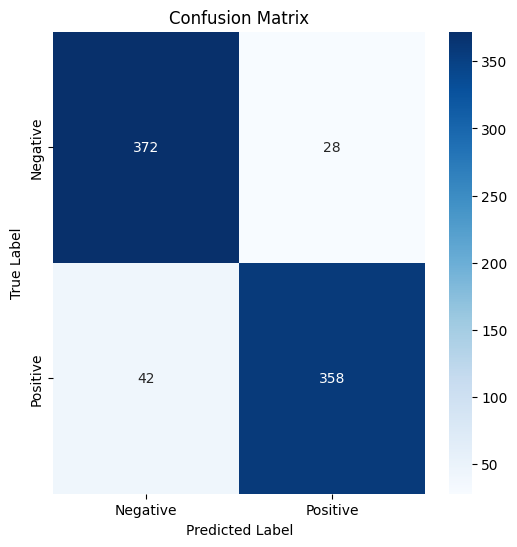

In [12]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0.0, 1.0])

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

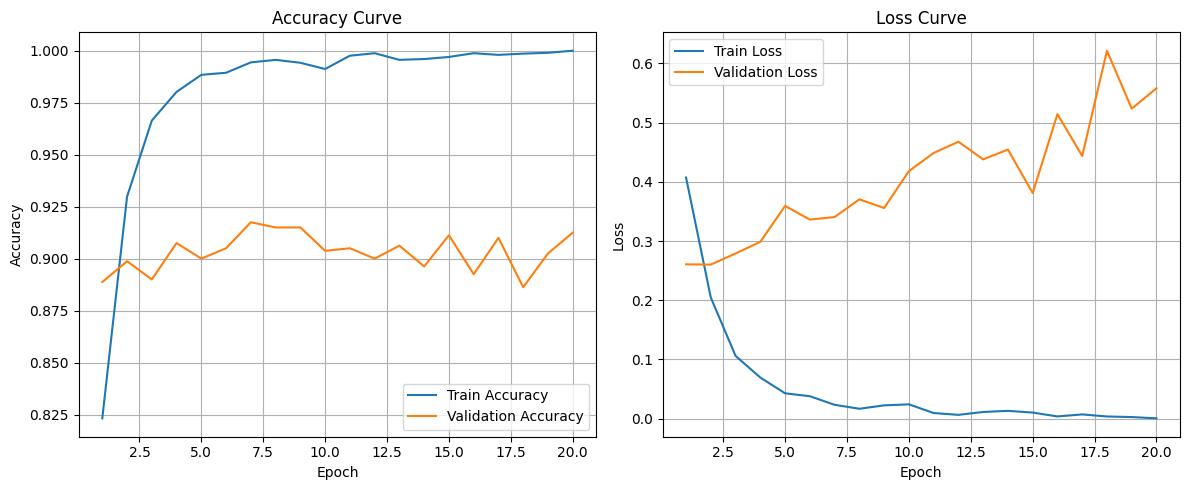

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)  # dynamically set length

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
if len(val_losses) == len(train_losses):  # Safe check
    plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
if len(val_accuracies) == len(train_accuracies):
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Define a function to predict sentiment of custom text input
def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    with torch.no_grad():
        # Tokenize input
        encoding = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=256
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Predict
        output = model(input_ids, attention_mask)
        prob = torch.sigmoid(output)

        # Result
        sentiment = "Positive" if prob.item() > 0.5 else "Negative"
        print(f"\nInput Text: {text}")
        print(f"Predicted Sentiment: {sentiment} (Confidence: {prob.item():.2f})")

# Example: Try predicting sentiment for new input
user_input = "Every one should watch the movie at least once"
predict_sentiment(user_input, model, tokenizer, device)

user_input = "This movie was boring and didn't make sense."
predict_sentiment(user_input, model, tokenizer, device)



Input Text: Every one should watch the movie at least once
Predicted Sentiment: Positive (Confidence: 0.67)

Input Text: This movie was boring and didn't make sense.
Predicted Sentiment: Negative (Confidence: 0.00)
